In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time

from itertools import product
from tqdm.notebook import tqdm
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np
import os
import ast

from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

# REGRESIÓN

## Lectura de datos

In [2]:
df = pd.read_csv('./datasets/data_treino_dv_df_2000_2010.csv')
df.head(1)

,HORA (UTC),"VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))","VENTO, VELOCIDADE HORARIA (m/s)",UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C),TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C),"UMIDADE RELATIVA DO AR, HORARIA (%)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)","PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)","VENTO, RAJADA MAXIMA (m/s)",PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,61.0,888.2,0.0,3.8,888.2,887.7


In [3]:
df.columns = ['HORA','WIND_DIR_HOR','WIND_VEL_HOR','HUM_REL_MAX_ANT','HUM_REL_MIN_ANT','TEMP_MAX_ANT','TEMP_MIN_ANT','HUM_REL_HOR','PRES_ATM_NIV','PREC_HOR','RAFAGA_VIENTO','PRES_ATM_MAX_ANT','PRES_ATM_MIN_ANT']
df.head(2)

,HORA,WIND_DIR_HOR,WIND_VEL_HOR,HUM_REL_MAX_ANT,HUM_REL_MIN_ANT,TEMP_MAX_ANT,TEMP_MIN_ANT,HUM_REL_HOR,PRES_ATM_NIV,PREC_HOR,RAFAGA_VIENTO,PRES_ATM_MAX_ANT,PRES_ATM_MIN_ANT
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,61.0,888.2,0.0,3.8,888.2,887.7
1,13:00,0.965926,2.7,62.0,55.0,24.2,22.5,55.0,888.4,0.0,4.7,888.4,888.2


In [4]:
df.drop(columns='HORA', inplace= True)

## Redes Neuronales

In [5]:
# Listar dispositivos disponibles
devices = tf.config.list_physical_devices('GPU')

if devices:
    print(f"TensorFlow está utilizando la GPU: {devices}")
else:
    print("TensorFlow no está utilizando la GPU")

TensorFlow está utilizando la GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### RNN

In [6]:
#df = df.iloc[:24*21*5]
df = df.iloc[-24*21*6:]
df.shape

(3024, 12)

In [7]:
# 🧠 Genera secuencias de entrenamiento para RNN y LSTM
def create_sequences(df, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        seq = df.iloc[i:i+window_size]
        X.append(seq.drop(columns=[target_col]).values)
        y.append(df.iloc[i+window_size][target_col])
    return np.array(X), np.array(y)

# 🧠 Construye un modelo RNN simple
def build_rnn_model(timesteps, input_dim, hidden_units, activation='tanh', learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, activation=activation, input_shape=(timesteps, input_dim)))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

In [8]:
def sliding_window_rnn_only( 
    df,
    target_col='WIND_VEL_HOR',
    T_values=[7, 14, 21],
    test_window=1,
    rnn_params={
        'hidden_units': [32, 64],
        'activation': ['tanh'],
        'learning_rate': [0.001],
        'epochs': [50],
        'batch_size': [32]
    },
    save_path='./progreso'
):
    os.makedirs(save_path, exist_ok=True)
    resultados_por_T = {}

    log_tiempos_path = os.path.join(save_path, 'tiempos_ejecucion.csv')
    if not os.path.exists(log_tiempos_path):
        with open(log_tiempos_path, 'w') as f:
            f.write('T_dias,modelo,parametros,duracion_segundos\n')

    for T in tqdm(T_values, desc="Procesando ventanas T"):
        print(f"\n🧭 Iniciando evaluación para ventana T={T} días...")
        inicio_ventana = time.time()
        T_hours = T * 24
        test_hours = test_window * 24
        extra = 1 * 24
        total_windows = len(df) - T_hours - test_hours - extra + 1
        output_path = os.path.join(save_path, f'RNN_resultados_T{T}.csv')

        if os.path.exists(output_path):
            df_prev = pd.read_csv(output_path)
            if 'params' in df_prev:
                df_prev['params'] = df_prev['params'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
        else:
            df_prev = pd.DataFrame(columns=['modelo', 'params', 'T_dias', 'T_horas', 'MAPE', 'MAE', 'RMSE', 'MSE', 'R2', 'LjungBox_p'])

        param_grid = list(product(*rnn_params.values()))
        param_keys = list(rnn_params.keys())
        model_type = 'RNN'

        for combo in param_grid:
            param_dict = dict(zip(param_keys, combo))
            ya_realizado = not df_prev.empty and ((df_prev['modelo'] == model_type) & (df_prev['params'].apply(lambda p: p == param_dict))).any()
            if ya_realizado:
                rmse = df_prev[((df_prev['modelo'] == model_type) & (df_prev['params'].apply(lambda p: p == param_dict)))]['RMSE'].values[0]
                print(f"⏩ Saltando modelo ya evaluado: {model_type} con hiperparámetros: {param_dict} y RMSE {rmse}")
                continue

            modelo_idx = param_grid.index(combo) + 1
            total_modelos = len(param_grid)
            progreso_modelo = (modelo_idx / total_modelos) * 100
            print(f"\n🔧 Modelo {modelo_idx}/{total_modelos} ({progreso_modelo:.1f}%) - {model_type} con hiperparámetros: {param_dict}")

            inicio_modelo = time.time()
            resultados = {k: [] for k in ['MAPE', 'MAE', 'RMSE', 'MSE', 'R2', 'LjungBox_p']}

            for start in tqdm(range(0, total_windows, 24), desc=f"     ↪ Subventanas ({model_type})", leave=False):
                data_window = df.iloc[start: start + T_hours + test_hours + extra].copy()
                train_data = data_window.iloc[:T_hours]
                test_data = data_window.iloc[T_hours:]

                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(train_data.drop(columns=[target_col]))
                X_test_scaled = scaler.fit_transform(test_data.drop(columns=[target_col]))

                train_scaled = pd.DataFrame(X_train_scaled, columns=train_data.columns.drop(target_col))
                train_scaled[target_col] = train_data[target_col].values

                test_scaled = pd.DataFrame(X_test_scaled, columns=test_data.columns.drop(target_col))
                test_scaled[target_col] = test_data[target_col].values

                scaled = pd.concat([train_scaled, test_scaled])
                X, y = create_sequences(scaled, target_col, T_hours)
                X_train, y_train = X[:-24], y[:-24]
                X_test, y_test = X[-24:], y[-24:]

                #print(f'Train set shape: {X_train.shape} y {y_train.shape}')
                #print(f'Test set shape: {X_test.shape} y {y_test.shape}')

                # 🔄 Reemplazo del modelo LSTM por RNN
                model = build_rnn_model(
                    timesteps=X_train.shape[1],
                    input_dim=X_train.shape[2],
                    hidden_units=param_dict['hidden_units'],
                    activation=param_dict['activation'],
                    learning_rate=param_dict['learning_rate']
                )

                early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
                model.fit(X_train, y_train, epochs=param_dict['epochs'], batch_size=param_dict['batch_size'], verbose=0, callbacks=[early_stop])
                y_pred = model.predict(X_test).flatten()

                residuals = y_test - y_pred
                resultados['MAPE'].append(mean_absolute_percentage_error(y_test, y_pred))
                resultados['MAE'].append(mean_absolute_error(y_test, y_pred))
                resultados['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
                resultados['MSE'].append(mean_squared_error(y_test, y_pred))
                resultados['R2'].append(r2_score(y_test, y_pred))
                ljung_p = acorr_ljungbox(residuals, lags=[1], return_df=True)['lb_pvalue'].iloc[0] if len(residuals) >= 2 else np.nan
                resultados['LjungBox_p'].append(ljung_p)

            nuevo_row = pd.DataFrame([{
                'modelo': model_type,
                'params': param_dict,
                'T_dias': T,
                'T_horas': T_hours,
                'MAPE': np.mean(resultados['MAPE']),
                'MAE': np.mean(resultados['MAE']),
                'RMSE': np.mean(resultados['RMSE']),
                'MSE': np.mean(resultados['MSE']),
                'R2': np.mean(resultados['R2']),
                'LjungBox_p': np.nanmean(resultados['LjungBox_p'])
            }])
            df_prev = pd.concat([df_prev, nuevo_row], ignore_index=True)
            df_prev.to_csv(output_path, index=False)

            duracion = time.time() - inicio_modelo
            with open(log_tiempos_path, 'a') as f:
                f.write(f'{T},{model_type},"{param_dict}",{duracion:.2f}\n')

            print(f"✅ Finalizado {model_type} con RMSE promedio: {np.mean(resultados['RMSE']):.4f} en {duracion:.2f} segundos")

        resultados_por_T[T] = df_prev
        duracion_ventana = time.time() - inicio_ventana
        print(f"🕒 Tiempo total para T={T} días: {duracion_ventana:.2f} segundos")

    return resultados_por_T


In [9]:
results = sliding_window_rnn_only( 
    df,
    target_col='WIND_VEL_HOR',
    T_values=[7, 14, 21],
    test_window=1,
    rnn_params={
        'hidden_units': [32, 64],
        'activation': ['tanh', 'relu'],
        'learning_rate': [0.001, 0.005],
        'epochs': [50],
        'batch_size': [32]
    },
    save_path='./progreso'
)

Procesando ventanas T:   0%|          | 0/3 [00:00<?, ?it/s]


🧭 Iniciando evaluación para ventana T=7 días...

🔧 Modelo 1/8 (12.5%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/118 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step
✅ Finalizado RNN con RMSE promedio: 2.8519 en 759.87 segundos

🔧 Modelo 2/8 (25.0%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'tanh', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/118 [00:00<?, ?it/s]

1/1 [==============================] - 0s 126ms/step
✅ Finalizado RNN con RMSE promedio: 2.5867 en 757.16 segundos

🔧 Modelo 3/8 (37.5%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/118 [00:00<?, ?it/s]

1/1 [==============================] - 0s 133ms/step
✅ Finalizado RNN con RMSE promedio: 1.5049 en 754.92 segundos

🔧 Modelo 4/8 (50.0%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'relu', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/118 [00:00<?, ?it/s]

1/1 [==============================] - 0s 122ms/step
✅ Finalizado RNN con RMSE promedio: 1.4797 en 752.76 segundos

🔧 Modelo 5/8 (62.5%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/118 [00:00<?, ?it/s]

1/1 [==============================] - 0s 128ms/step
✅ Finalizado RNN con RMSE promedio: 2.6666 en 740.82 segundos

🔧 Modelo 6/8 (75.0%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'tanh', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/118 [00:00<?, ?it/s]

1/1 [==============================] - 0s 127ms/step
✅ Finalizado RNN con RMSE promedio: 2.5664 en 733.76 segundos

🔧 Modelo 7/8 (87.5%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/118 [00:00<?, ?it/s]

1/1 [==============================] - 0s 123ms/step
✅ Finalizado RNN con RMSE promedio: 1.4085 en 729.00 segundos

🔧 Modelo 8/8 (100.0%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'relu', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/118 [00:00<?, ?it/s]

1/1 [==============================] - 0s 123ms/step
✅ Finalizado RNN con RMSE promedio: 1.5006 en 731.27 segundos
🕒 Tiempo total para T=7 días: 5959.57 segundos

🧭 Iniciando evaluación para ventana T=14 días...

🔧 Modelo 1/8 (12.5%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/111 [00:00<?, ?it/s]

1/1 [==============================] - 0s 143ms/step
✅ Finalizado RNN con RMSE promedio: 2.7059 en 1238.35 segundos

🔧 Modelo 2/8 (25.0%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'tanh', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/111 [00:00<?, ?it/s]

1/1 [==============================] - 0s 143ms/step
✅ Finalizado RNN con RMSE promedio: 2.5827 en 1203.80 segundos

🔧 Modelo 3/8 (37.5%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/111 [00:00<?, ?it/s]

1/1 [==============================] - 0s 139ms/step
✅ Finalizado RNN con RMSE promedio: 1.4874 en 1227.56 segundos

🔧 Modelo 4/8 (50.0%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'relu', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/111 [00:00<?, ?it/s]

1/1 [==============================] - 0s 158ms/step
✅ Finalizado RNN con RMSE promedio: 1.5404 en 1178.27 segundos

🔧 Modelo 5/8 (62.5%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/111 [00:00<?, ?it/s]

1/1 [==============================] - 0s 139ms/step
✅ Finalizado RNN con RMSE promedio: 2.7115 en 1224.65 segundos

🔧 Modelo 6/8 (75.0%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'tanh', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/111 [00:00<?, ?it/s]

1/1 [==============================] - 0s 146ms/step
✅ Finalizado RNN con RMSE promedio: 2.7415 en 1168.75 segundos

🔧 Modelo 7/8 (87.5%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/111 [00:00<?, ?it/s]

1/1 [==============================] - 0s 142ms/step
✅ Finalizado RNN con RMSE promedio: 1.3487 en 1226.64 segundos

🔧 Modelo 8/8 (100.0%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'relu', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/111 [00:00<?, ?it/s]

1/1 [==============================] - 0s 146ms/step
✅ Finalizado RNN con RMSE promedio: 6893084425.6141 en 1162.60 segundos
🕒 Tiempo total para T=14 días: 9630.62 segundos

🧭 Iniciando evaluación para ventana T=21 días...

🔧 Modelo 1/8 (12.5%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/104 [00:00<?, ?it/s]

1/1 [==============================] - 0s 160ms/step
✅ Finalizado RNN con RMSE promedio: 2.7171 en 1661.00 segundos

🔧 Modelo 2/8 (25.0%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'tanh', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/104 [00:00<?, ?it/s]

1/1 [==============================] - 0s 164ms/step
✅ Finalizado RNN con RMSE promedio: 2.5971 en 1644.51 segundos

🔧 Modelo 3/8 (37.5%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/104 [00:00<?, ?it/s]

1/1 [==============================] - 0s 165ms/step
✅ Finalizado RNN con RMSE promedio: 1.5089 en 1645.84 segundos

🔧 Modelo 4/8 (50.0%) - RNN con hiperparámetros: {'hidden_units': 32, 'activation': 'relu', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/104 [00:00<?, ?it/s]

1/1 [==============================] - 0s 164ms/step
✅ Finalizado RNN con RMSE promedio: 1.4782 en 1606.74 segundos

🔧 Modelo 5/8 (62.5%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'tanh', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/104 [00:00<?, ?it/s]

1/1 [==============================] - 0s 164ms/step
✅ Finalizado RNN con RMSE promedio: 2.7324 en 1643.89 segundos

🔧 Modelo 6/8 (75.0%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'tanh', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/104 [00:00<?, ?it/s]

1/1 [==============================] - 0s 160ms/step
✅ Finalizado RNN con RMSE promedio: 2.6793 en 1658.69 segundos

🔧 Modelo 7/8 (87.5%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'relu', 'learning_rate': 0.001, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/104 [00:00<?, ?it/s]

1/1 [==============================] - 0s 162ms/step
✅ Finalizado RNN con RMSE promedio: 1.3426 en 1657.12 segundos

🔧 Modelo 8/8 (100.0%) - RNN con hiperparámetros: {'hidden_units': 64, 'activation': 'relu', 'learning_rate': 0.005, 'epochs': 50, 'batch_size': 32}


     ↪ Subventanas (RNN):   0%|          | 0/104 [00:00<?, ?it/s]

1/1 [==============================] - 0s 168ms/step
✅ Finalizado RNN con RMSE promedio: 1.4682 en 1612.14 segundos
🕒 Tiempo total para T=21 días: 13129.94 segundos


## Resultados

In [10]:

def plot_rmse_bar(df, title='RMSE por Modelo', sort_ascending=True, figsize=(12, 6)):
    """
    Genera una gráfica de barras del RMSE por modelo, ordenada según el valor del RMSE.

    Parámetros:
    - df: DataFrame que debe contener las columnas 'modelo', 'params' y 'RMSE'.
    - title: Título de la gráfica.
    - sort_ascending: Booleano, si True ordena de menor a mayor RMSE.
    - figsize: Tamaño de la figura (tupla).

    Retorna:
    - None (muestra la gráfica).
    """
    df_sorted = df.sort_values(by="RMSE", ascending=sort_ascending)
    etiquetas = df_sorted['modelo'].astype(str) + ' ' + df_sorted['params'].astype(str)

    plt.figure(figsize=figsize)
    plt.bar(etiquetas, df_sorted['RMSE'])
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('RMSE')
    plt.title(title)
    plt.tight_layout()
    plt.show()

Leer resultados de los modelos evaluados.

In [11]:
## Sin escalar
df_ns_7 = pd.read_csv('./progreso/reg_resultados_T7.csv')
df_ns_14 = pd.read_csv('./progreso/reg_resultados_T14.csv')
df_ns_21 = pd.read_csv('./progreso/reg_resultados_T21.csv')

##Escalados
df_s_7 = pd.read_csv('./progreso/s_resultados_T7.csv')
df_s_14 = pd.read_csv('./progreso/s_resultados_T14.csv')
df_s_21 = pd.read_csv('./progreso/s_resultados_T21.csv')

## RNN
df_mlp_7 = pd.read_csv('./progreso/mlp_resultados_T7.csv')
df_mlp_14 = pd.read_csv('./progreso/mlp_resultados_T14.csv')
df_mlp_21 = pd.read_csv('./progreso/mlp_resultados_T21.csv')


df_w_7 = pd.concat([df_ns_7, df_s_7, df_mlp_7])
df_w_14 = pd.concat([df_ns_14, df_s_14, df_mlp_14])
df_w_21 = pd.concat([df_ns_21, df_s_21,df_mlp_21])


In [12]:
df_mlp_7.sort_values('RMSE', ascending=True).head(1)

,modelo,params,T_dias,T_horas,MAPE,MAE,RMSE,MSE,R2,LjungBox_p
34,mlp,"{'hidden_layers': [16, 32, 64], 'activation': ...",7,168,7.692282e+13,0.974689,1.163154,1.510879,-0.715096,0.074596


In [13]:
df_w_7.sort_values('RMSE', ascending=True).head(50)

,modelo,params,T_dias,T_horas,MAPE,MAE,RMSE,MSE,R2,LjungBox_p
37,ramdon_forest,"{'n_estimators': 100, 'max_depth': 5, 'n_jobs'...",7,168,1.819711e+14,0.820842,1.010022,1.103412,-0.111556,0.163861
38,xgb_regressor,"{'random_state': 0, 'learning_rate': 0.01, 'n_...",7,168,2.098130e+14,0.868695,1.061471,1.214722,-0.198293,0.136177
34,SVR,"{'C': 1.0, 'epsilon': 0.2, 'kernel': 'rbf'}",7,168,2.045502e+14,0.936311,1.129961,1.407422,-0.480588,0.107738
32,SVR,"{'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'}",7,168,2.038768e+14,0.936610,1.130695,1.409169,-0.483522,0.107736
30,SVR,"{'C': 1.0, 'epsilon': 0.01, 'kernel': 'rbf'}",7,168,2.034521e+14,0.937135,1.131494,1.410944,-0.486285,0.107364
40,SVR,"{'C': 10, 'epsilon': 0.2, 'kernel': 'rbf'}",7,168,2.036482e+14,0.940270,1.135522,1.418891,-0.501396,0.105096
38,SVR,"{'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}",7,168,2.027771e+14,0.940977,1.136785,1.421893,-0.505703,0.105172
36,SVR,"{'C': 10, 'epsilon': 0.01, 'kernel': 'rbf'}",7,168,2.022194e+14,0.941803,1.138151,1.425044,-0.510023,0.105697
26,SVR,"{'C': 0.1, 'epsilon': 0.1, 'kernel': 'rbf'}",7,168,2.276767e+14,0.964461,1.161676,1.479488,-0.489282,0.090026
28,SVR,"{'C': 0.1, 'epsilon': 0.2, 'kernel': 'rbf'}",7,168,2.284899e+14,0.964581,1.161857,1.479542,-0.488034,0.089759


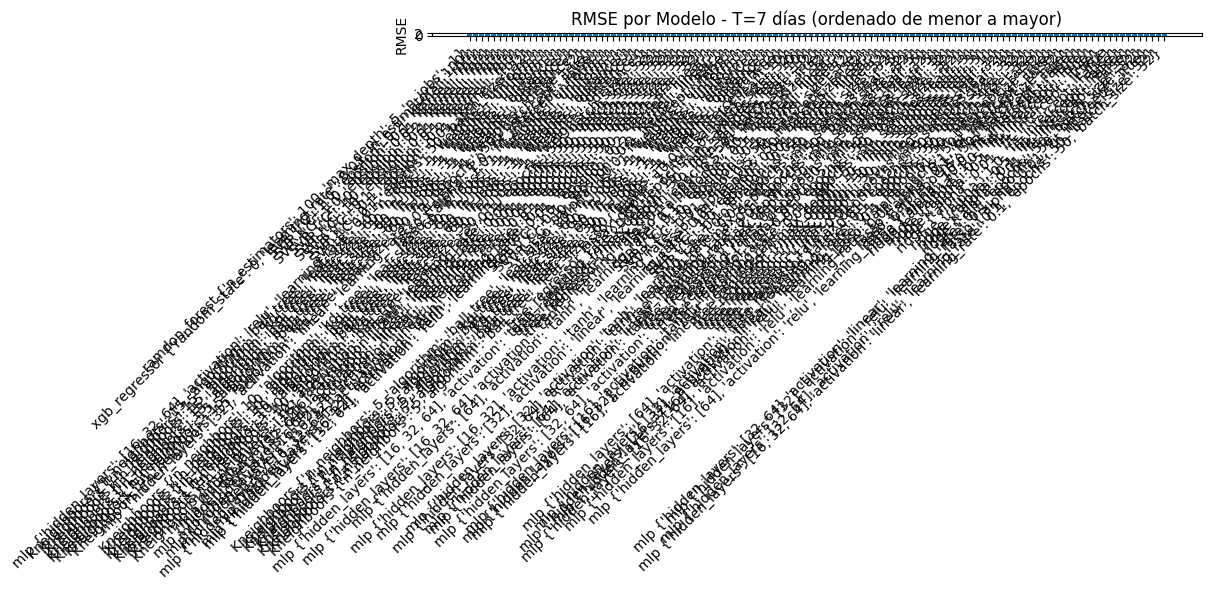

In [14]:
# Ver los DataFrames en memoria
plot_rmse_bar(df_w_7, title='RMSE por Modelo - T=7 días (ordenado de menor a mayor)', sort_ascending=True)
